In [28]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import os
import pathlib
import pandas as pd
import re

%matplotlib inline
AUTOTUNE = tf.data.experimental.AUTOTUNE

import sys
sys.path.append('..')
from utilities import Timer

from tensorflow.keras.models             import Sequential, load_model, Sequential
from tensorflow.keras.layers             import Conv2D, MaxPool2D, InputLayer, Dropout, Dense, Flatten
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers         import Adam
from tensorflow.keras.metrics            import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.losses             import CategoricalCrossentropy
from tensorflow.keras.callbacks          import CSVLogger, EarlyStopping, ModelCheckpoint, TerminateOnNaN

# Load data as a TensorFlow dataset

Largely based on the TensorFlow [tutorial](https://www.tensorflow.org/tutorials/load_data/images)

In [11]:
width = height = 224
batch_size = 128

In [14]:
# Load the classnames

df = pd.read_excel('../dataset/artist-breakdown-annotated.xlsx')
df = df[df.fillna(0).keep.astype(bool)]
class_names = df.artist.unique()
class_names.sort()

In [15]:
def load_dataset(data_subdir, 
                 shuffle = True, shuffle_buffer_size=1000,
                 batch_size = batch_size,
                 width      = width,
                 height     = height
                ):
    # Load the list of file names in the form of data_dir/class_name/file_name.jpg
    data_dir = pathlib.Path('../dataset/images/') / pathlib.Path(data_subdir)
    list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

    dataset_size = len(list(list_ds))
    
    # Function to get the label
    def get_label(file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        return parts[-2] == class_names
    
    # Function to get the image
    def decode_img(file_path):
        # Load the image
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        
        # Scale image pixels to 0/1
        img = tf.image.convert_image_dtype(img, tf.float32)
        # Resize
        return tf.image.resize(img, [width, height])
    
    # Combine both processes
    def process_path(file_path):
        return decode_img(file_path), get_label(file_path)
    
    # Create the dataset
    ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.cache()
    
    if shuffle:
        if shuffle_buffer_size is not None:
            ds = ds.shuffle(buffer_size = shuffle_buffer_size)
        else:
            ds = ds.shuffle(buffer_size = dataset_size)
    
    ds = ds.repeat().batch(batch_size).prefetch(buffer_size = AUTOTUNE)    
    return ds, dataset_size

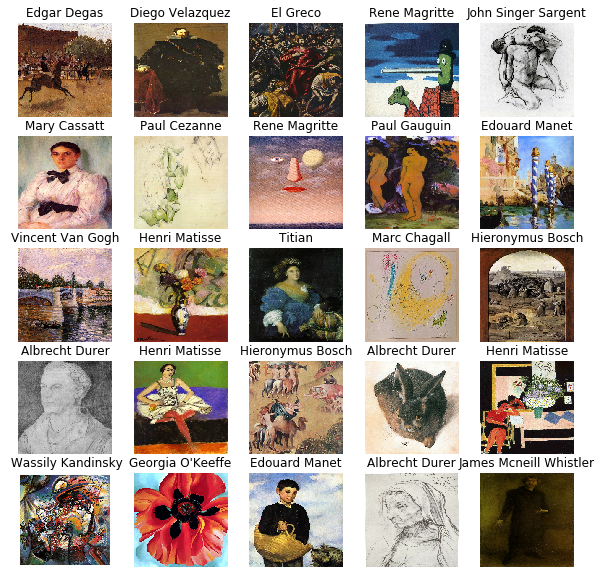

In [16]:
# Look at a batch
peek, peek_size = load_dataset('train', shuffle_buffer_size=32)
image_batch, label_batch = next(iter(peek))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

## Build Classifier

### Setup
Helper functions to set tracking callbacks with different logs for each model, define metrics, and some helper functions to view logs and load the most recent saved model

In [17]:
# Helper Function to set callbacks based on model_name
def get_callbacks(model_name):
    return [
        CSVLogger(f'./logs/{model_name}-log.csv', append = True),
        EarlyStopping(patience = 5, restore_best_weights = False),
        ModelCheckpoint(filepath=f'./logs/models/{model_name}'+'-{epoch:02d}.hdf5'),
        TerminateOnNaN()
    ]

# Metrics to track
metrics   = [
    CategoricalAccuracy(name = 'accuracy'),
    TopKCategoricalAccuracy(3, name = 'top-3-accuracy'),
    TopKCategoricalAccuracy(5, name = 'top-5-accuracy'),
]

# Helper Function to get fitting history
def get_fitting_history(model_name):
    log_file_name = f'./logs/{model_name}-log.csv'
    hist = pd.read_csv(log_file_name)
    hist       = pd.read_csv(log_file_name)
    max_epoch  = hist.epoch.max()
    best_epoch = hist.set_index('epoch').val_loss.idxmax()
    if len(hist.epoch) != len(hist.epoch.unique()):
        print('Warning: some epochs were fit multiple times')
    return max_epoch, best_epoch, hist

# Helper functions to get most recently saved model
model_dir = './logs/models/'
def get_saved_models(model_name):
    fnames = os.listdir(model_dir)
    model_epochs = {}
    for fname in fnames:
        re_ = re.match(f'{model_name}-(\d*)', fname)
        if re_:
            epoch = int(re_.group(1))
            if epoch in model_epochs:
                print(f'Warning, multiple models for {model_name}-{epoch}. '
                      f'Ignoring {model_epochs[epoch]} in favor of {fname}')
            model_epochs[epoch] = fname


def get_most_recent_saved_model(model_name, model, remove_old = False):
    saved_models = get_saved_models(model_name)
    if len(model_epochs) == 0:
        print(f'No previous models found')
        return model, 0
    else:
        max_epoch = max(model_epochs.keys())
        print(f'Most recent: epoch {max_epoch} found in {model_epochs[max_epoch]} being loaded')
        max_model = load_model('./logs/models/' + model_epochs[max_epoch])
        out = (max_model, max_epoch + 1)
    
        # Possibly remove old models to conserve memory
        if not remove_old:
            return out
        else:
            for epoch in saved_models:
                if epoch < max_epoch:
                    print(f'Removing old model {model_epochs[epoch]}')
                    os.remove(model_dir + model_epochs[epoch])
    
def view_all_saved_models():
    root   = './logs/models/'
    fnames = os.listdir(root)
    df = []
    for fname in fnames:
        df.append({'file' : fname,
                   'size_mb' : os.path.getsize(root+fname)/1000000})
    df = pd.DataFrame.from_records(df)
    print(f'Total of {df.size_mb.sum()} MB of stored models on disk')
    return df

### Attempt 1
The original DeepDream was built using [GoogLeNet](https://arxiv.org/abs/1409.4842) which won the ILSVRC (ImageNet Large Scale Visual Recognition Competition) in [2014](http://image-net.org/challenges/LSVRC/2014/).

In the spirit of keeping things simple, a first attempt will be made using a VGGNet (from the [Visual Geometry Group at Oxford](https://www.robots.ox.ac.uk/~vgg/)). This placed 2nd in ILSVRC 2014 but is substantially simpler in architecture, being essentially a vanilla convolutional net.

We don't want to use the pre-existing weights, so we will attempt to train from scratch. You can see the model on the tensorflow [github](https://github.com/tensorflow/tensorflow/blob/23c3bdaacdc27bb82dfd1772efefad687508923a/tensorflow/python/keras/applications/vgg19.py). Note that it is not precisely the same as described in the paper

In [7]:
# Load Data
train, train_size       = load_dataset('train')
validate, validate_size = load_dataset('validate', shuffle=False)

# Load a blank VGG-19
model_name = 'vgg19'
model = VGG19(include_top = True, weights = None, input_shape = (width, height, 3), classes = len(class_names))
print(model.summary());

# Compile the model
optimizer = Adam()
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved(model_name, model)

history = model.fit(
    train,
    validation_data  = validate,
    epochs           = 30,
    verbose          = 1,
    callbacks        = get_callbacks(model_name),
    validation_steps = validate_size // batch_size + 1,
    steps_per_epoch  = train_size    // batch_size + 1,
    initial_epoch    = next_epoch
)

### Attempt 2
Training from scratch was a bit of a tall order. Let's start with transfer learning

In [18]:
# Let's try a smaller batch size
batch_size = 32

# Load Data
train, train_size       = load_dataset('train', batch_size = batch_size)
validate, validate_size = load_dataset('validate', shuffle=False, batch_size = batch_size)

# Load a pre-trained VGG-19
model_name = 'vgg19-INet-top'
model = VGG19(include_top = False, weights = 'imagenet', input_shape = (width, height, 3))
model = Sequential(model.layers, name = 'vgg19-INet')

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Add new top layers in the same format
model.add(Flatten())
model.add(Dense(4096, activation = 'relu'))
model.add(Dense(4096, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax'))

# Compile the model
optimizer = Adam()
model.compile(optimizer, 
              loss = CategoricalCrossentropy(),
              metrics = metrics)
print(model.summary())

# Find the most recent epoch run
model, next_epoch = get_most_recent_saved(model_name, model)

history = model.fit(
    train,
    validation_data  = validate,
    epochs           = 30,
    verbose          = 1,
    callbacks        = get_callbacks(model_name),
    validation_steps = validate_size // batch_size + 1,
    steps_per_epoch  = train_size    // batch_size + 1,
    initial_epoch    = next_epoch
)